In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pywt
import os     

        

In [7]:
# Función para convertir valores de ADC a milivoltios (mV)
def ADCtomV(ADC, n=10, VCC=3.3):
    volts = (((ADC / (2**n)) - (1 / 2)) * VCC) / 1009
    return volts * 1000

In [8]:

# Función para leer el archivo OpenSignals
def leer_senal_opensignals(archivo):
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    # Buscar la línea que contiene el JSON con los parámetros
    for linea in lineas:
        if linea.startswith('# {'):
            json_data = json.loads(linea[2:])
            break
    
    device_key = list(json_data.keys())[0]  # Primera clave del JSON (ID del dispositivo)
    fs = json_data[device_key]["sampling rate"]
    titulo = json_data[device_key]["label"]

    inicio_datos = 0
    for i, linea in enumerate(lineas):
        if 'EndOfHeader' in linea:
            inicio_datos = i + 1
            break
    
    data = pd.read_csv(archivo, delimiter='\t', skiprows=inicio_datos, header=None)
    tiempo = np.arange(len(data)) / fs
    senal = data.iloc[:, -1]  # Última columna (A1)

    return tiempo, senal, fs, titulo
        

In [9]:

# Función para aplicar Wavelet Denoise
def wavelet_denoise(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs_filt = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(coeffs_filt, wavelet)
    denoised_signal = denoised_signal[:len(data)]
    
    return denoised_signal
        

In [10]:

# Normalizacion de señal tipo MIN-MAX
def normalizar(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
        

In [11]:
# Funciones de características adicionales
def cambios_signo_pendiente(x, epsilon=0):
    cambios = 0
    for k in range(1, len(x) - 1):
        if (x[k] > x[k-1] and x[k] < x[k+1]) or (x[k] < x[k-1] and x[k] > x[k+1]):
            if np.abs(x[k] - x[k+1]) >= epsilon:
                cambios += 1
    return cambios

def longitud_forma_onda(x):
    return np.sum(np.abs(np.diff(x)))
# Función para calcular características del EMG en mV
def extraer_caracteristicas(data):
    rms = np.sqrt(np.mean(data**2))  # RMS en mV
    mav = np.mean(np.abs(data))  # MAV en mV
    wl = np.sum(np.abs(np.diff(data)))  # WL en mV
    zc = np.sum(np.diff(np.sign(data)) != 0)  # ZC sin unidades
    ssc = np.sum(np.diff(np.sign(np.diff(data))) != 0)  # SSC sin unidades
    
    # Características adicionales
    csp = cambios_signo_pendiente(data)  # Cambios de signo de pendiente
    lfo = longitud_forma_onda(data)  # Longitud de forma de onda
    iav = np.sum(np.abs(data))  # IAV en mV
    var = np.var(data)  # Varianza en mV²
    threshold = np.mean(data)  # Umbral en mV
    nf = np.sum((data[:-1] >= threshold) != (data[1:] >= threshold))  # Número de cruces de umbral (NF)

    return {
        "RMS (mV)": rms,
        "MAV (mV)": mav,
        "WL (mV)": wl,
        "ZC (sin unidades)": zc,
        "SSC (sin unidades)": ssc,
        "CSP (sin unidades)": csp,
        "LFO (mV)": lfo,
        "IAV (mV)": iav,
        "Varianza (mV²)": var,
        "Threshold (mV)": threshold,
        "NF (sin unidades)": nf
    }


In [12]:
# Función para graficar la señal sin características
def graficar_senal(tiempo, senal, senal_filtrada, titulo):
    plt.figure(figsize=(12, 6))

    # Señal original
    plt.subplot(2, 1, 1)
    plt.plot(tiempo, senal, label='Señal original', color='blue')
    plt.title(f'Señal EMG - {titulo}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (mV)')
    plt.grid(True)
    plt.legend()

    # Señal filtrada
    plt.subplot(2, 1, 2)
    plt.plot(tiempo, senal_filtrada, label='Señal filtrada con Wavelet', color='green')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud filtrada (mV)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps1_reposo.txt


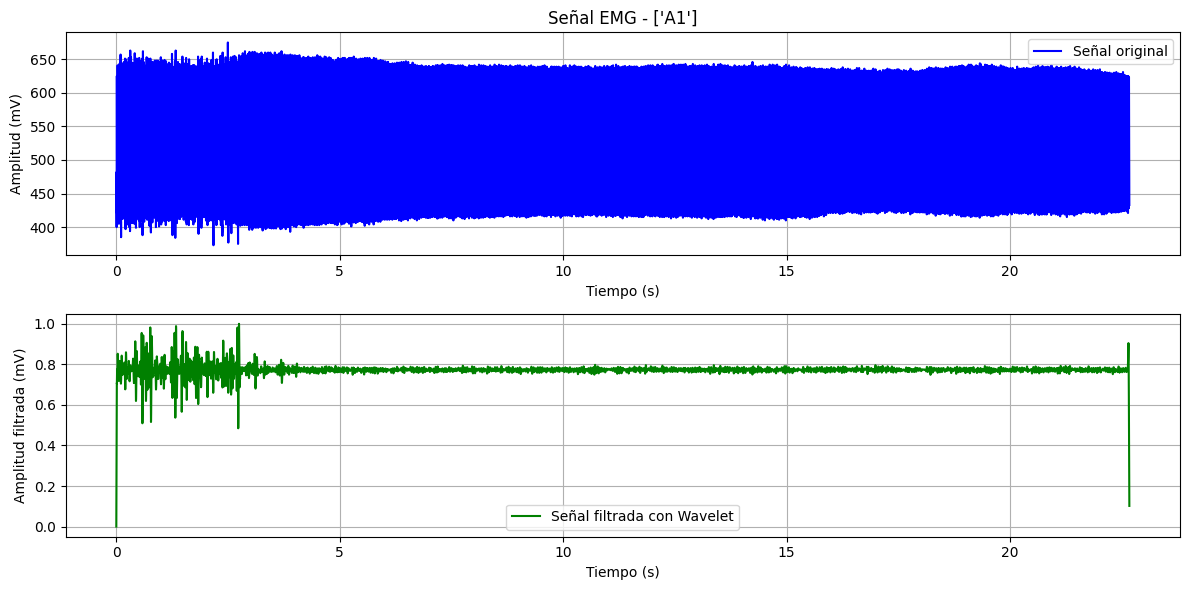

Características del EMG:
RMS (mV): 0.7728
MAV (mV): 0.7723
WL (mV): 43.4638
ZC (sin unidades): 1.0000
SSC (sin unidades): 1623.0000
CSP (sin unidades): 21042.0000
LFO (mV): 43.4638
IAV (mV): 17504.7023
Varianza (mV²): 0.0008
Threshold (mV): 0.7723
NF (sin unidades): 962.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps2_mov_voluntario.txt


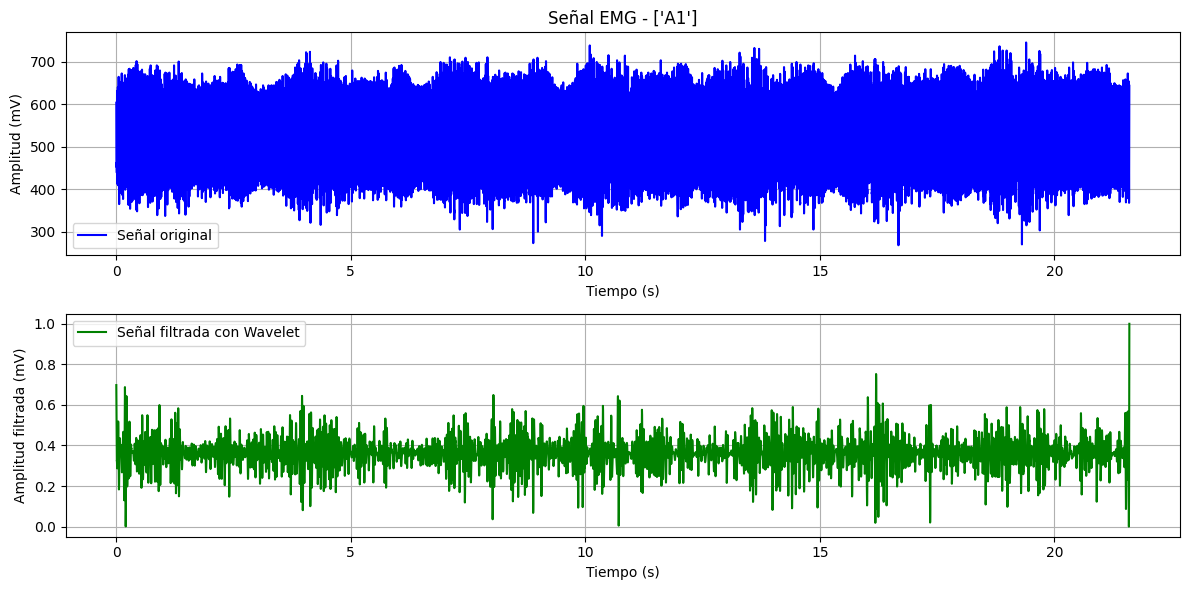

Características del EMG:
RMS (mV): 0.3694
MAV (mV): 0.3618
WL (mV): 203.5500
ZC (sin unidades): 2.0000
SSC (sin unidades): 1609.0000
CSP (sin unidades): 19990.0000
LFO (mV): 203.5500
IAV (mV): 7816.2264
Varianza (mV²): 0.0055
Threshold (mV): 0.3618
NF (sin unidades): 1088.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps3_mov_fuerza.txt


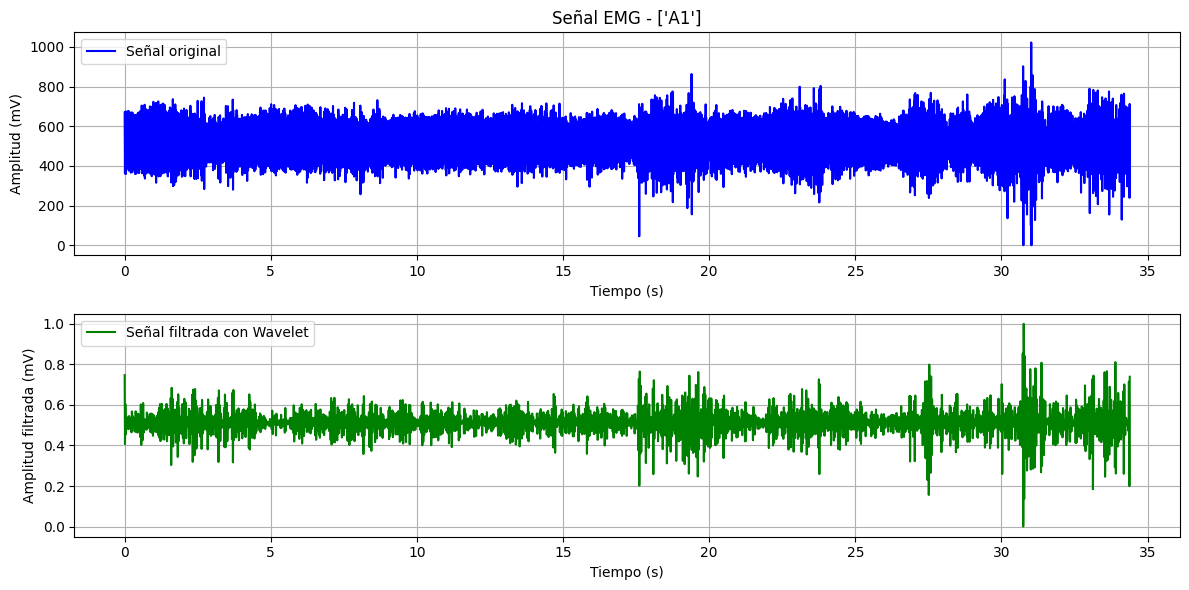

Características del EMG:
RMS (mV): 0.5154
MAV (mV): 0.5125
WL (mV): 225.0002
ZC (sin unidades): 2.0000
SSC (sin unidades): 2495.0000
CSP (sin unidades): 31892.0000
LFO (mV): 225.0002
IAV (mV): 17624.1007
Varianza (mV²): 0.0030
Threshold (mV): 0.5125
NF (sin unidades): 1746.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro1_reposo.txt


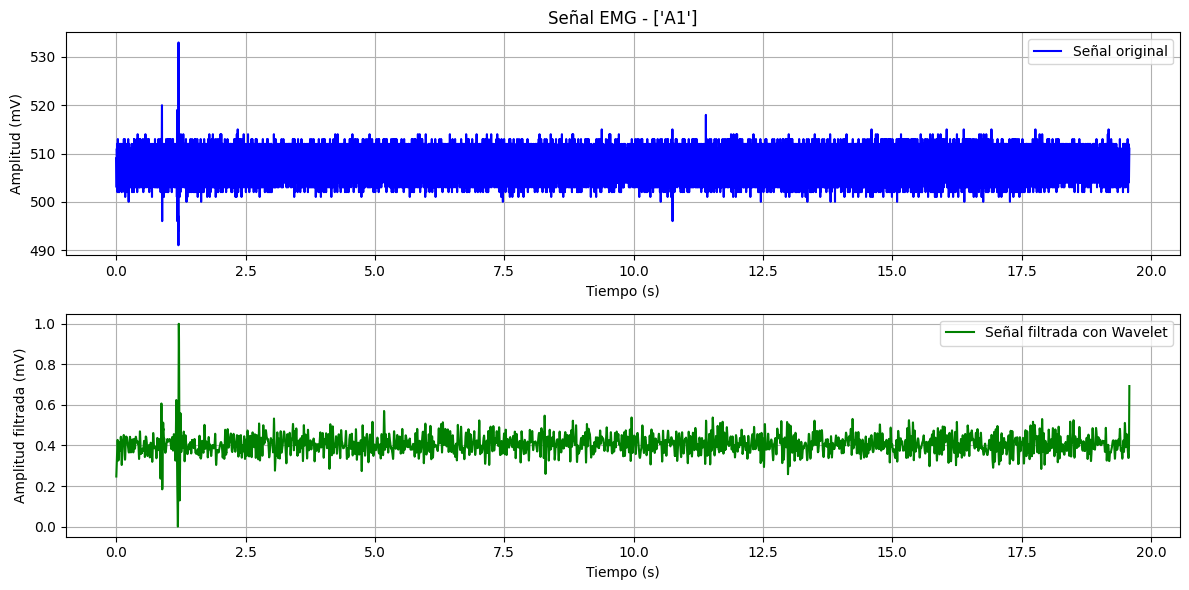

Características del EMG:
RMS (mV): 0.4088
MAV (mV): 0.4064
WL (mV): 86.9380
ZC (sin unidades): 2.0000
SSC (sin unidades): 1384.0000
CSP (sin unidades): 18198.0000
LFO (mV): 86.9380
IAV (mV): 7957.9909
Varianza (mV²): 0.0020
Threshold (mV): 0.4064
NF (sin unidades): 793.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro2_mov_voluntario.txt


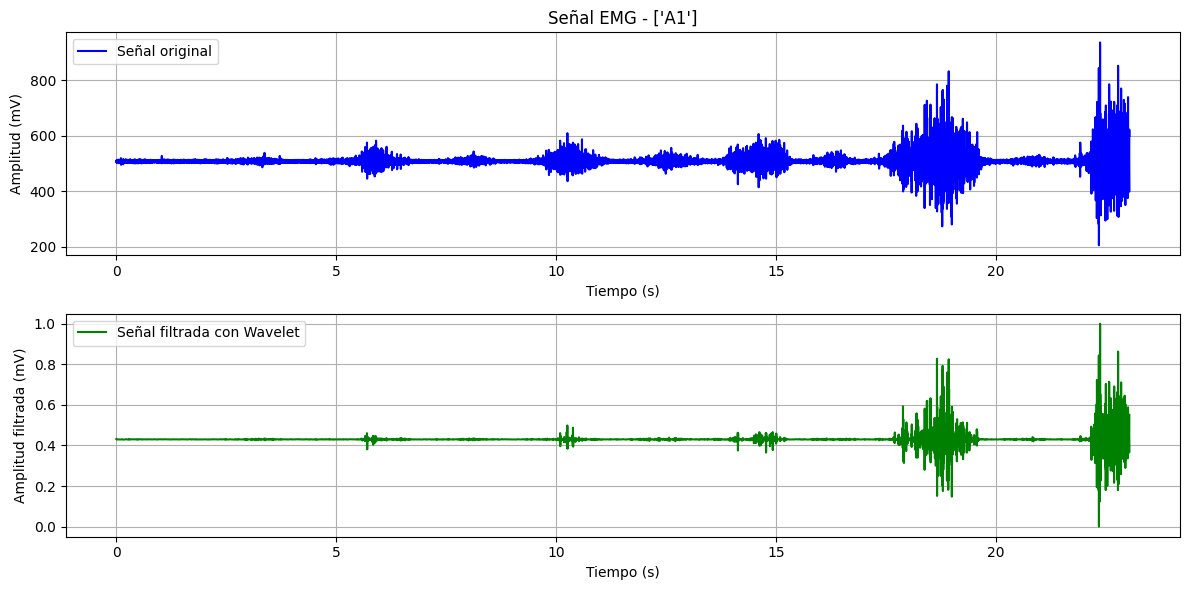

Características del EMG:
RMS (mV): 0.4306
MAV (mV): 0.4300
WL (mV): 95.9563
ZC (sin unidades): 2.0000
SSC (sin unidades): 2457.0000
CSP (sin unidades): 20582.0000
LFO (mV): 95.9563
IAV (mV): 9907.5563
Varianza (mV²): 0.0005
Threshold (mV): 0.4300
NF (sin unidades): 1640.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro3_mov_fuerza.txt


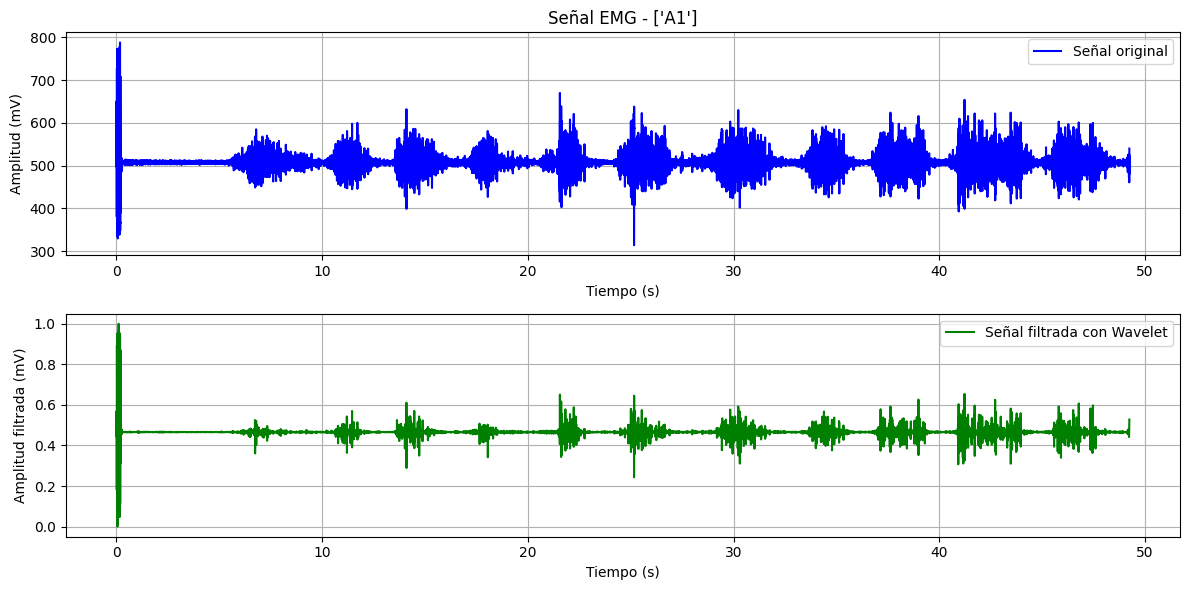

Características del EMG:
RMS (mV): 0.4665
MAV (mV): 0.4660
WL (mV): 142.5047
ZC (sin unidades): 2.0000
SSC (sin unidades): 5440.0000
CSP (sin unidades): 43796.0000
LFO (mV): 142.5047
IAV (mV): 22944.4305
Varianza (mV²): 0.0005
Threshold (mV): 0.4660
NF (sin unidades): 3627.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps1_reposo.txt


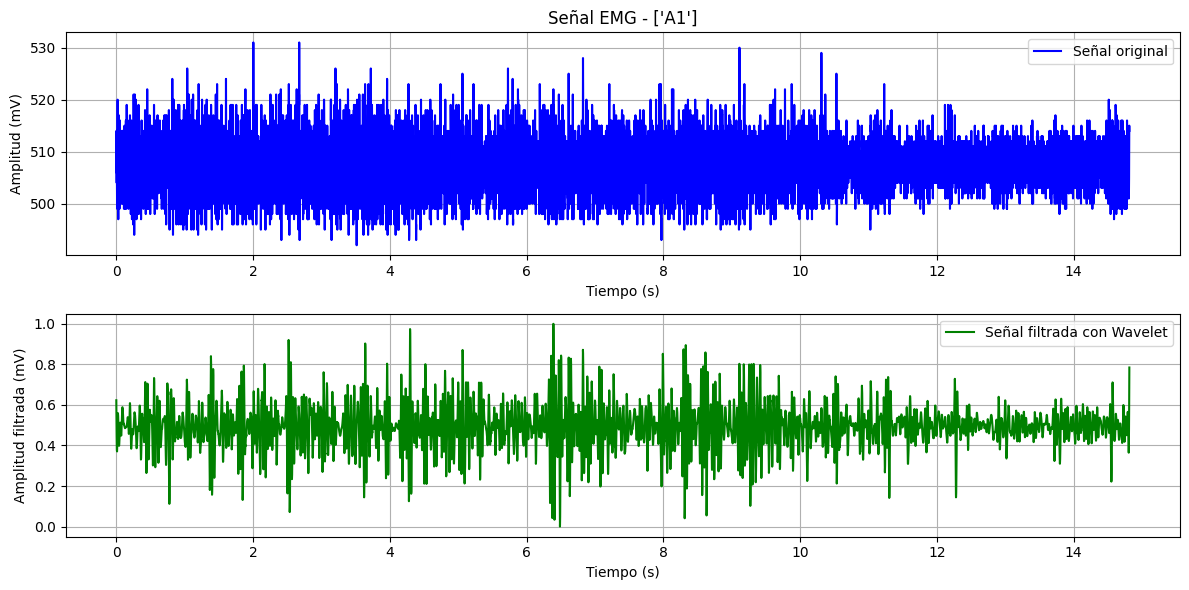

Características del EMG:
RMS (mV): 0.5045
MAV (mV): 0.4934
WL (mV): 191.9882
ZC (sin unidades): 2.0000
SSC (sin unidades): 1071.0000
CSP (sin unidades): 13743.0000
LFO (mV): 191.9882
IAV (mV): 7310.0352
Varianza (mV²): 0.0110
Threshold (mV): 0.4934
NF (sin unidades): 736.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps2_mov_voluntario.txt


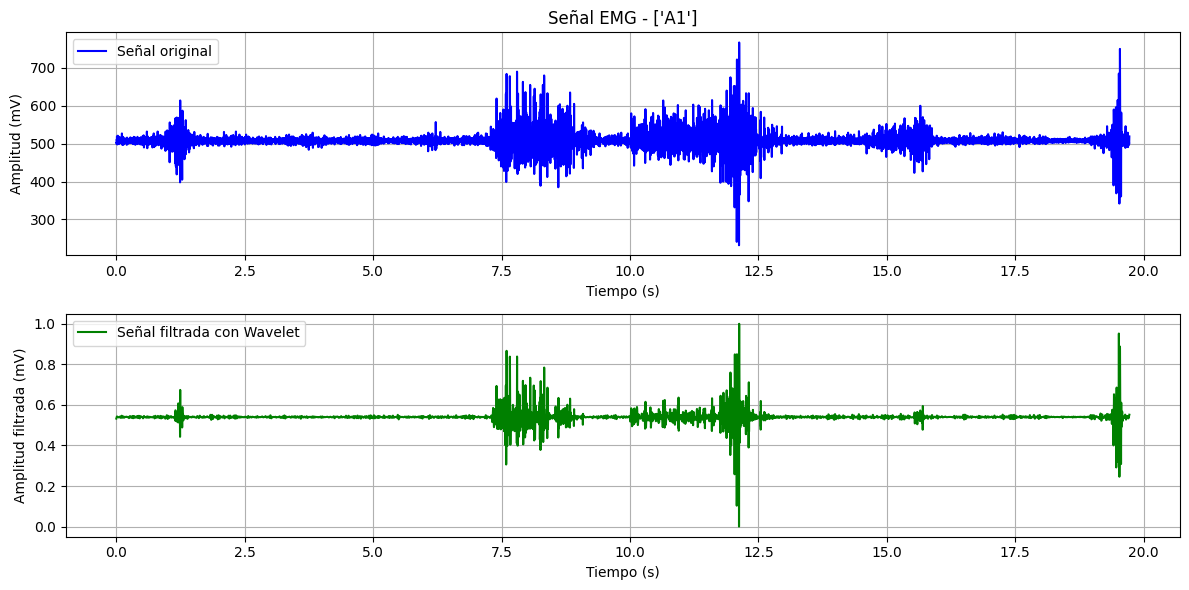

Características del EMG:
RMS (mV): 0.5407
MAV (mV): 0.5402
WL (mV): 65.5542
ZC (sin unidades): 2.0000
SSC (sin unidades): 1914.0000
CSP (sin unidades): 17807.0000
LFO (mV): 65.5542
IAV (mV): 10653.5196
Varianza (mV²): 0.0006
Threshold (mV): 0.5402
NF (sin unidades): 1287.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps3_mov_fuerza.txt


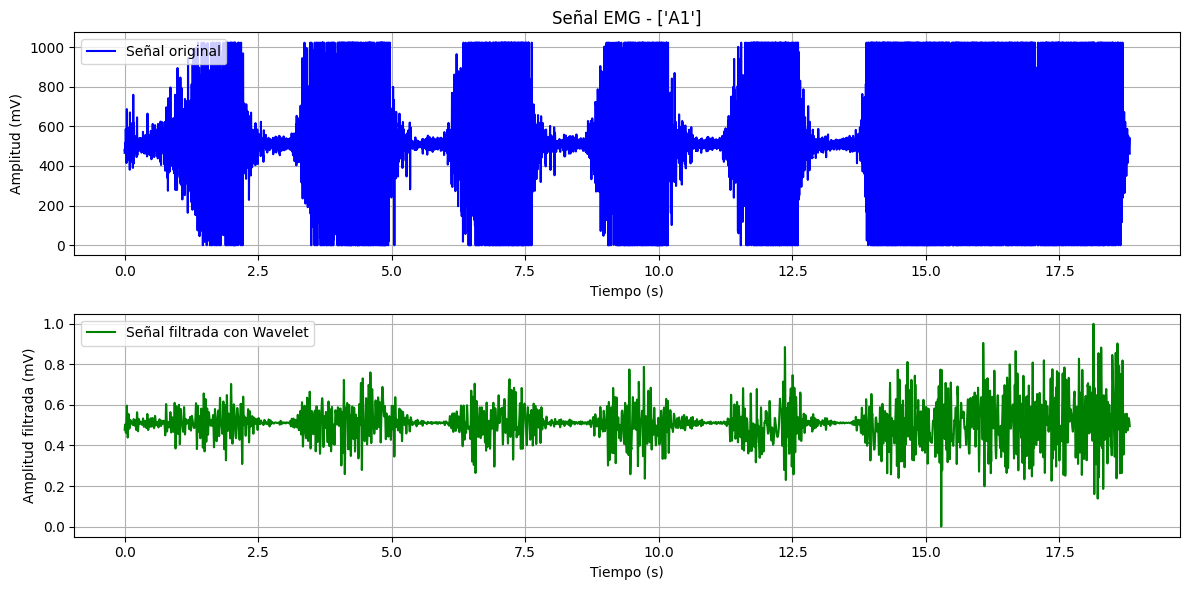

Características del EMG:
RMS (mV): 0.5159
MAV (mV): 0.5098
WL (mV): 165.2068
ZC (sin unidades): 2.0000
SSC (sin unidades): 1487.0000
CSP (sin unidades): 17327.0000
LFO (mV): 165.2068
IAV (mV): 9591.4750
Varianza (mV²): 0.0064
Threshold (mV): 0.5098
NF (sin unidades): 892.0000

--------------------------------------------------



In [13]:
# Lista de archivos para procesar
archivos = [
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps3_mov_fuerza.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro3_mov_fuerza.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps3_mov_fuerza.txt"
]

# Procesar cada archivo
for archivo in archivos:
    print(f"Procesando archivo: {archivo}")
    
    # Leer el archivo y procesar la señal
    tiempo, senal, fs, titulo = leer_senal_opensignals(archivo)
    
    # Aplicar Wavelet Denoise
    senal_filtrada = wavelet_denoise(senal)
    
    # Normalizar señal filtrada
    senal_normalizada = normalizar(senal_filtrada)
    
    # Extraer características del EMG
    caracteristicas = extraer_caracteristicas(senal_normalizada)
    
    # Graficar señal original y filtrada sin las características
    graficar_senal(tiempo, senal, senal_normalizada, titulo)
    
    # Mostrar características como texto
    print("Características del EMG:")
    for nombre, valor in caracteristicas.items():
        print(f"{nombre}: {valor:.4f}")
    print("\n" + "-"*50 + "\n")



In [16]:
# Función para crear una carpeta y guardar los gráficos en el escritorio
def guardar_grafico(tiempo, senal, senal_filtrada, archivo):
    # Definir la carpeta en el escritorio
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    carpeta = os.path.join(desktop_path, "ploteoss")
    
    # Crear la carpeta si no existe
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)
    
    # Configuración del gráfico
    plt.figure(figsize=(12, 6))
    
    # Nombre del archivo sin extensión como título
    titulo = os.path.basename(archivo).replace('.txt', '')

    # Señal original
    plt.subplot(2, 1, 1)
    plt.plot(tiempo, senal, label='Señal original', color='blue')
    plt.title(f'Señal EMG - {titulo}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (mV)')
    plt.grid(True)
    plt.legend()

    # Señal filtrada
    plt.subplot(2, 1, 2)
    plt.plot(tiempo, senal_filtrada, label='Señal filtrada con Wavelet', color='green')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud filtrada (mV)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    
    # Guardar gráfico con el nombre del archivo en la carpeta
    nombre_archivo = f"{titulo}.png"
    ruta_guardado = os.path.join(carpeta, nombre_archivo)
    plt.savefig(ruta_guardado)
    plt.close()
    print(f"Gráfico guardado en: {ruta_guardado}")

In [17]:
# Lista de archivos para procesar
archivos = [
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps3_mov_fuerza.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\gastro3_mov_fuerza.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps1_reposo.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps2_mov_voluntario.txt",
    r"C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\triceps3_mov_fuerza.txt"
]

# Procesar cada archivo
for archivo in archivos:
    print(f"Procesando archivo: {archivo}")
    
    # Leer el archivo y procesar la señal
    tiempo, senal, fs, titulo = leer_senal_opensignals(archivo)
    
    # Aplicar Wavelet Denoise
    senal_filtrada = wavelet_denoise(senal)
    
    # Normalizar señal filtrada
    senal_normalizada = normalizar(senal_filtrada)
    
    # Extraer características del EMG
    caracteristicas = extraer_caracteristicas(senal_normalizada)
    
    # Guardar gráfico de la señal original y filtrada en la carpeta "ploteoss" en el escritorio
    guardar_grafico(tiempo, senal, senal_normalizada, archivo)
    
    # Mostrar características como texto
    print("Características del EMG:")
    for nombre, valor in caracteristicas.items():
        print(f"{nombre}: {valor:.4f}")
    print("\n" + "-"*50 + "\n")



Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps1_reposo.txt
Gráfico guardado en: C:\Users\LENOVO\Desktop\ploteoss\biceps1_reposo.png
Características del EMG:
RMS (mV): 0.7728
MAV (mV): 0.7723
WL (mV): 43.4638
ZC (sin unidades): 1.0000
SSC (sin unidades): 1623.0000
CSP (sin unidades): 21042.0000
LFO (mV): 43.4638
IAV (mV): 17504.7023
Varianza (mV²): 0.0008
Threshold (mV): 0.7723
NF (sin unidades): 962.0000

--------------------------------------------------

Procesando archivo: C:\Users\LENOVO\Desktop\4_10_ISB\Laboratorios\Laboratorio 4\Dataset\biceps2_mov_voluntario.txt
Gráfico guardado en: C:\Users\LENOVO\Desktop\ploteoss\biceps2_mov_voluntario.png
Características del EMG:
RMS (mV): 0.3694
MAV (mV): 0.3618
WL (mV): 203.5500
ZC (sin unidades): 2.0000
SSC (sin unidades): 1609.0000
CSP (sin unidades): 19990.0000
LFO (mV): 203.5500
IAV (mV): 7816.2264
Varianza (mV²): 0.0055
Threshold (mV): 0.3618
NF (sin unidades): 1088.0000

----------------